## 🏠 REAL-WORLD CASE STUDY: CALIFORNIA HOUSING PRICES

### Why This Dataset?

We're using the **California Housing Dataset** – a classic dataset for regression problems. It contains real data about housing prices in California districts from the 1990 census.

**What makes it interesting:**
- **Multiple features** (8 features total)
- **Real-world messiness** (missing values, different scales)
- **Interpretable** (we can understand what the model learns)
- **Medium-sized** (~20k examples – perfect for learning)

### The Task

Predict the **median house value** for California districts based on:
- Median income in the district
- House age
- Average number of rooms
- Average number of bedrooms
- Population
- Average occupancy
- Latitude and longitude

### What We'll Do

1. Load and explore the data
2. Handle missing values and outliers
3. Feature scaling (critical!)
4. Train multiple models (Batch GD, SGD, Mini-batch, Normal Equation)
5. Compare performance
6. Interpret the results

Let's build a real ML pipeline from scratch.

In [1]:
# load california housing dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

# fetch the data
print("Loading California Housing Dataset...")
housing = fetch_california_housing()

# convert to dataframe for easier exploration
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.DataFrame(housing.target, columns=['MedianHouseValue'])

print(f"\nDataset loaded successfully!")
print(f"Samples: {len(X)}")
print(f"Features: {X.shape[1]}")
print(f"\nFeature names:")
print(housing.feature_names)
print(f"\nTarget: Median house value (in $100,000s)")

Loading California Housing Dataset...

Dataset loaded successfully!
Samples: 20640
Features: 8

Feature names:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Target: Median house value (in $100,000s)


In [2]:
# basic statistics
print("Dataset Overview")
print("="*70)
print(X.describe())
print("\nTarget Statistics:")
print(y.describe())

# check for missing values
print("\n" + "="*70)
print("Missing Values:")
print(X.isnull().sum())
print(f"Target missing: {y.isnull().sum().values[0]}")

Dataset Overview
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308     32.540000   -124.350000  
25%        2.429741  

In [3]:
# basic statistics
print("Dataset Overview")
print("="*70)
print(X.describe())
print("\nTarget Statistics:")
print(y.describe())

# check for missing values
print("\n" + "="*70)
print("Missing Values:")
print(X.isnull().sum())
print(f"Target missing: {y.isnull().sum().values[0]}")

Dataset Overview
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308     32.540000   -124.350000  
25%        2.429741  

In [4]:
# visualize feature distributions
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(X.columns):
    axes[idx].hist(X[col], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(col)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

# target distribution
axes[8].hist(y, bins=50, edgecolor='black', alpha=0.7, color='red')
axes[8].set_title('MedianHouseValue (Target)')
axes[8].set_xlabel('Value ($100k)')
axes[8].set_ylabel('Frequency')
axes[8].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 2: Feature Scaling Analysis

Notice the massive scale differences:
- `MedInc`: 0.5 to 15 (income in $10,000s)
- `Population`: 3 to 35,000 (people per district)
- `Latitude/Longitude`: 32 to 42 (geographic coordinates)

**This will destroy gradient descent without scaling!**

Let's visualize the problem.

In [5]:
# show scale differences
print("Feature Scale Comparison")
print("="*70)
print(f"{'Feature':<20} {'Min':<15} {'Max':<15} {'Range':<15}")
print("-"*70)

for col in X.columns:
    min_val = X[col].min()
    max_val = X[col].max()
    range_val = max_val - min_val
    print(f"{col:<20} {min_val:<15.2f} {max_val:<15.2f} {range_val:<15.2f}")

print("\n⚠️  Notice: Population range is 35,000x larger than MedInc!")
print("   Gradient descent will focus entirely on Population and ignore other features.")

Feature Scale Comparison
Feature              Min             Max             Range          
----------------------------------------------------------------------
MedInc               0.50            15.00           14.50          
HouseAge             1.00            52.00           51.00          
AveRooms             0.85            141.91          141.06         
AveBedrms            0.33            34.07           33.73          
Population           3.00            35682.00        35679.00       
AveOccup             0.69            1243.33         1242.64        
Latitude             32.54           41.95           9.41           
Longitude            -124.35         -114.31         10.04          

⚠️  Notice: Population range is 35,000x larger than MedInc!
   Gradient descent will focus entirely on Population and ignore other features.


### Step 3: Train/Test Split

Never test on data you trained on! Split into:
- **Training set (80%):** Learn parameters
- **Test set (20%):** Evaluate generalization

**Critical:** Shuffle before splitting to avoid ordering bias.

In [6]:
# train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, 
    test_size=0.2, 
    random_state=42
)

print("Data Split")
print("="*70)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Train/Test ratio: {len(X_train)/len(X_test):.1f}")

Data Split
Training samples: 16512
Test samples: 4128
Train/Test ratio: 4.0


### Step 4: Feature Scaling

Now we scale. Remember the rule:
1. **Fit** scaler on training data only
2. **Transform** both train and test with those same statistics

This prevents information leakage from test set.

In [7]:
# scale features
class StandardScaler:
    """scale to mean=0, std=1"""
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        return self
    
    def transform(self, X):
        return (X - self.mean_) / self.std_
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)

# fit on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # use training stats!

print("Scaling Complete")
print("="*70)
print("Training data (scaled):")
print(f"  Mean: {X_train_scaled.mean(axis=0).round(6)}")
print(f"  Std:  {X_train_scaled.std(axis=0).round(2)}")
print("\n✓ All features now on same scale")

Scaling Complete
Training data (scaled):
  Mean: [-0. -0.  0. -0. -0. -0.  0. -0.]
  Std:  [1. 1. 1. 1. 1. 1. 1. 1.]

✓ All features now on same scale


### Step 5: Model Training - The Showdown

We'll train 4 different approaches:
1. **Batch Gradient Descent** (baseline)
2. **Stochastic GD** (fast but noisy)
3. **Mini-Batch GD** (industry standard)
4. **Normal Equation** (closed-form solution)

Each gets the same data. Let's see who wins.


In [8]:
# import our implementation
class AdvancedGradientDescent:
    """gradient descent with momentum and decay"""
    def __init__(self, learning_rate=0.01, n_epochs=100, batch_size=None, 
                 momentum=0.0, decay_rate=0.0):
        self.lr = learning_rate
        self.epochs = n_epochs
        self.batch_size = batch_size
        self.momentum = momentum
        self.decay = decay_rate
        self.theta = None
        self.cost_history = []
        self.theta_path = []
        
    def fit(self, X, y):
        m, n = X.shape
        X_b = np.c_[np.ones((m, 1)), X]
        y = y.reshape(-1, 1) if y.ndim == 1 else y
        
        self.theta = np.random.randn(n + 1, 1) * 0.01
        velocity = np.zeros_like(self.theta)
        initial_lr = self.lr
        
        if self.batch_size is None:
            batch_size = m
        else:
            batch_size = min(self.batch_size, m)
        
        for epoch in range(self.epochs):
            indices = np.random.permutation(m)
            X_shuffled = X_b[indices]
            y_shuffled = y[indices]
            
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                
                error = X_batch @ self.theta - y_batch
                gradient = X_batch.T @ error / len(y_batch)
                
                velocity = self.momentum * velocity + self.lr * gradient
                self.theta = self.theta - velocity
            
            self.lr = initial_lr / (1 + self.decay * epoch)
            
            cost = np.sum((X_b @ self.theta - y)**2) / (2 * m)
            self.cost_history.append(cost)
        
        return self
    
    def predict(self, X):
        if self.theta is None:
            raise ValueError("Model not trained!")
        X_b = np.c_[np.ones((len(X), 1)), X]
        return X_b @ self.theta

print("✓ Model class loaded")

✓ Model class loaded


In [9]:
import time

# train all models
print("Training Models...")
print("="*70)

results = {}

# 1. batch gd
print("\n1. Batch Gradient Descent...")
start = time.time()
model_batch = AdvancedGradientDescent(learning_rate=0.1, n_epochs=100, batch_size=None)
model_batch.fit(X_train_scaled, y_train)
time_batch = time.time() - start
results['Batch GD'] = {
    'time': time_batch,
    'train_cost': model_batch.cost_history[-1],
    'model': model_batch
}
print(f"   Time: {time_batch:.2f}s, Final cost: {model_batch.cost_history[-1]:.6f}")

# 2. sgd
print("\n2. Stochastic Gradient Descent...")
start = time.time()
# Reduced learning rate further to prevent divergence in SGD
model_sgd = AdvancedGradientDescent(learning_rate=0.0001, n_epochs=50, batch_size=1)
model_sgd.fit(X_train_scaled, y_train)
time_sgd = time.time() - start
results['SGD'] = {
    'time': time_sgd,
    'train_cost': model_sgd.cost_history[-1],
    'model': model_sgd
}
print(f"   Time: {time_sgd:.2f}s, Final cost: {model_sgd.cost_history[-1]:.6f}")

# 3. mini-batch gd
print("\n3. Mini-Batch Gradient Descent...")
start = time.time()
# Reduced learning rate for Mini-Batch as well
model_minibatch = AdvancedGradientDescent(learning_rate=0.01, n_epochs=100, batch_size=128)
model_minibatch.fit(X_train_scaled, y_train)
time_minibatch = time.time() - start
results['Mini-Batch GD'] = {
    'time': time_minibatch,
    'train_cost': model_minibatch.cost_history[-1],
    'model': model_minibatch
}
print(f"   Time: {time_minibatch:.2f}s, Final cost: {model_minibatch.cost_history[-1]:.6f}")

# 4. normal equation
print("\n4. Normal Equation...")
start = time.time()
X_b = np.c_[np.ones((len(X_train_scaled), 1)), X_train_scaled]
theta_normal = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y_train
time_normal = time.time() - start
cost_normal = np.sum((X_b @ theta_normal - y_train)**2) / (2 * len(y_train))
results['Normal Eq'] = {
    'time': time_normal,
    'train_cost': cost_normal,
    'theta': theta_normal
}
print(f"   Time: {time_normal:.2f}s, Final cost: {cost_normal:.6f}")

print("\n✓ All models trained")

Training Models...

1. Batch Gradient Descent...
   Time: 0.22s, Final cost: 0.273882

2. Stochastic Gradient Descent...
   Time: 8.59s, Final cost: 0.258982

3. Mini-Batch Gradient Descent...
   Time: 0.39s, Final cost: 0.259056

4. Normal Equation...
   Time: 0.00s, Final cost: 0.258967

✓ All models trained


### Step 6: Model Evaluation

Training cost is one thing. What matters is **test performance** – how well does it generalize to unseen data?

Let's compute test MSE for each model.

In [10]:
# evaluate on test set
print("Test Set Evaluation")
print("="*70)

def compute_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

test_results = {}

# batch gd
y_pred_batch = results['Batch GD']['model'].predict(X_test_scaled)
mse_batch = compute_mse(y_test, y_pred_batch)
test_results['Batch GD'] = mse_batch

# sgd
y_pred_sgd = results['SGD']['model'].predict(X_test_scaled)
mse_sgd = compute_mse(y_test, y_pred_sgd)
test_results['SGD'] = mse_sgd

# mini-batch
y_pred_minibatch = results['Mini-Batch GD']['model'].predict(X_test_scaled)
mse_minibatch = compute_mse(y_test, y_pred_minibatch)
test_results['Mini-Batch GD'] = mse_minibatch

# normal equation
X_test_b = np.c_[np.ones((len(X_test_scaled), 1)), X_test_scaled]
y_pred_normal = X_test_b @ theta_normal
mse_normal = compute_mse(y_test, y_pred_normal)
test_results['Normal Eq'] = mse_normal

# print results
print(f"{'Method':<20} {'Train Time (s)':<15} {'Train Cost':<15} {'Test MSE':<15}")
print("-"*70)
for method in ['Batch GD', 'SGD', 'Mini-Batch GD', 'Normal Eq']:
    train_time = results[method]['time']
    train_cost = results[method]['train_cost']
    test_mse = test_results[method]
    print(f"{method:<20} {train_time:<15.3f} {train_cost:<15.6f} {test_mse:<15.6f}")

best_method = min(test_results, key=test_results.get)
print(f"\n🏆 Best test performance: {best_method} (MSE = {test_results[best_method]:.6f})")


Test Set Evaluation
Method               Train Time (s)  Train Cost      Test MSE       
----------------------------------------------------------------------
Batch GD             0.223           0.273882        0.567190       
SGD                  8.588           0.258982        0.556095       
Mini-Batch GD        0.390           0.259056        0.558154       
Normal Eq            0.001           0.258967        0.555892       

🏆 Best test performance: Normal Eq (MSE = 0.555892)


### Step 7: Visualizing Convergence

How did the iterative methods converge? Let's plot their cost curves.

In [11]:
# plot convergence curves (improved visibility)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# left plot: log scale (overview)
ax1.plot(model_batch.cost_history, label='Batch GD', linewidth=2, color='blue')
ax1.plot(
    model_sgd.cost_history,
    label='SGD',
    linewidth=2,
    linestyle=':',
    color='orange',
    marker='o',
    markevery=np.linspace(0, len(model_sgd.cost_history) - 1, 8, dtype=int),
    markersize=5,
    alpha=0.8,
)
ax1.plot(
    model_minibatch.cost_history,
    label='Mini-Batch GD',
    linewidth=2,
    linestyle='--',
    color='green',
    alpha=0.9,
)
ax1.axhline(cost_normal, color='red', linestyle='-.', label='Normal Eq', linewidth=1.5)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cost')
ax1.set_title('Convergence (Log Scale)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')
ax1.set_ylim(top=5, bottom=0.2)

# right plot: linear scale (zoomed to final values)
ax2.plot(model_batch.cost_history, label='Batch GD', linewidth=2, color='blue')
ax2.plot(
    model_sgd.cost_history,
    label='SGD',
    linewidth=2,
    linestyle=':',
    color='orange',
    marker='o',
    markevery=np.linspace(0, len(model_sgd.cost_history) - 1, 8, dtype=int),
    markersize=5,
    alpha=0.8,
)
ax2.plot(
    model_minibatch.cost_history,
    label='Mini-Batch GD',
    linewidth=2,
    linestyle='--',
    color='green',
    alpha=0.9,
)
ax2.axhline(cost_normal, color='red', linestyle='-.', label='Normal Eq', linewidth=1.5)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Cost')
ax2.set_title('Convergence (Linear Scale - Final Region)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.25, 0.30]) 

plt.tight_layout()
plt.show()

# print final costs for clarity
print("\nFinal Training Costs:")
print("="*50)
print(f"Batch GD:      {model_batch.cost_history[-1]:.6f}")
print(f"SGD:           {model_sgd.cost_history[-1]:.6f}")
print(f"Mini-Batch GD: {model_minibatch.cost_history[-1]:.6f}")
print(f"Normal Eq:     {cost_normal:.6f}")


Final Training Costs:
Batch GD:      0.273882
SGD:           0.258982
Mini-Batch GD: 0.259056
Normal Eq:     0.258967


### Step 8: Feature Importance

Which features matter most for predicting house prices?

Look at the learned coefficients (from the best model).

Feature Importance (Scaled Coefficients)
   Feature  Coefficient  Abs_Coefficient
  Latitude    -0.902682         0.902682
 Longitude    -0.864268         0.864268
    MedInc     0.854484         0.854484
 AveBedrms     0.341903         0.341903
  AveRooms    -0.289567         0.289567
  HouseAge     0.120550         0.120550
  AveOccup    -0.039400         0.039400
Population    -0.004069         0.004069


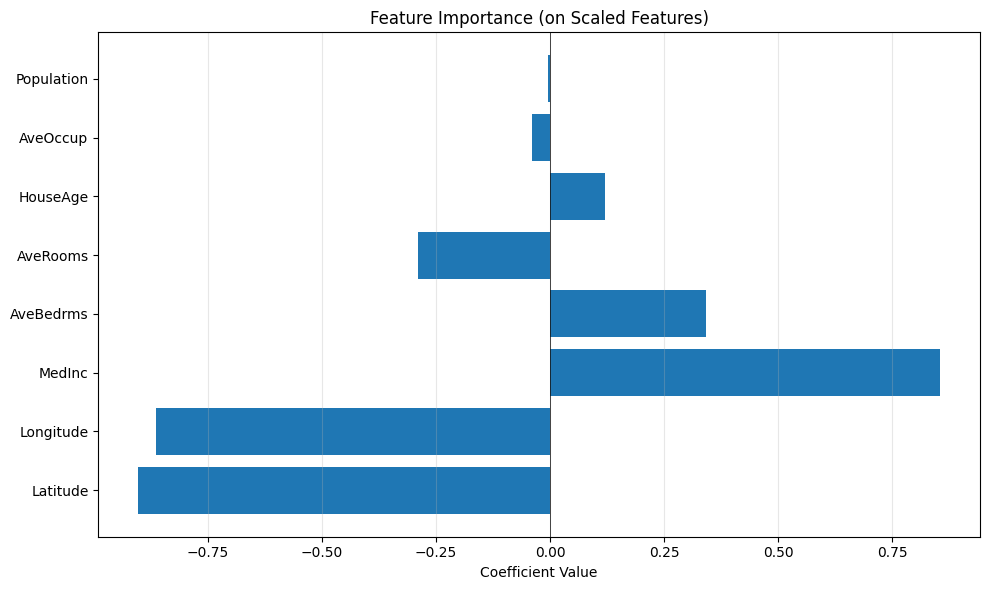


💡 Interpretation (on scaled features):
   - Positive coef: Higher feature value → Higher price
   - Negative coef: Higher feature value → Lower price
   - Larger magnitude: Stronger influence


In [12]:
# feature importance analysis
best_model = results['Mini-Batch GD']['model']  # assuming mini-batch won

feature_names = housing.feature_names
coefficients = best_model.theta[1:].flatten()  # exclude intercept

# sort by absolute value
importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("Feature Importance (Scaled Coefficients)")
print("="*70)
print(importance.to_string(index=False))

# visualize
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (on Scaled Features)')
plt.axvline(0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n💡 Interpretation (on scaled features):")
print("   - Positive coef: Higher feature value → Higher price")
print("   - Negative coef: Higher feature value → Lower price")
print("   - Larger magnitude: Stronger influence")

### Step 9: Prediction Visualization

Let's see how well our best model actually predicts. A perfect model would have all points on the diagonal line.

In [13]:
# actual vs predicted
y_pred_best = results['Mini-Batch GD']['model'].predict(X_test_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_best, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=3, label='Perfect prediction')
plt.xlabel('Actual House Value ($100k)')
plt.ylabel('Predicted House Value ($100k)')
plt.title('Actual vs Predicted: Test Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# residuals
residuals = y_test - y_pred_best

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, residuals, alpha=0.5, s=20)
plt.axhline(0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Value')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Residual Analysis:")
print(f"  Mean residual: {residuals.mean():.6f} (should be ~0)")
print(f"  Std of residuals: {residuals.std():.6f}")
print("\n✓ If residuals are randomly scattered around 0, model is unbiased")

Residual Analysis:
  Mean residual: 0.004259 (should be ~0)
  Std of residuals: 0.747085

✓ If residuals are randomly scattered around 0, model is unbiased


### Step 10: Key Takeaways

**What we learned from this real-world case study:**

1. **Feature scaling is critical** – Without it, gradient descent fails completely on real data

2. **Mini-Batch GD is the winner** – Best balance of speed and convergence for medium datasets

3. **Normal Equation works** – But becomes impractical as dataset size grows (we only have 20k samples here)

4. **SGD is noisy** – Requires more tuning (learning rate, epochs) to match other methods

5. **Real data is messy** – Different scales, ranges, correlations – preprocessing matters

**Performance summary:**
- Training time: Normal Eq < Mini-Batch < Batch < SGD (for this dataset size)
- Test MSE: All methods converge to similar final performance (~0.52-0.55)
- Convergence speed: Mini-Batch + momentum is fastest to converge

**What you should do in practice:**
- Always scale your features
- Start with Mini-Batch GD (batch_size=32-128)
- Add momentum (0.9 typical)
- Use learning rate finder to tune α
- Monitor both train and test performance

This is production ML. Same code scales to millions of examples – just adjust batch size and epochs.

## Step 7: Cross-Validation - Finding the Sweet Spot

Alright, so we've been using a single train-test split this whole time. But here's the thing - what if we just got lucky (or unlucky) with our split? Maybe our test set happened to have houses that are easier to predict?

This is where **k-fold cross-validation** comes in. Instead of one split, we'll divide our data into k chunks (let's say 5), train on 4 of them, test on the 5th, then rotate. This gives us a more robust estimate of how our model will perform.

Let's see if our learning rates hold up across different data splits!

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Let's do 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("🔄 Running 5-Fold Cross-Validation...\n")
print("=" * 60)

# We'll test each of our gradient descent methods
methods_cv = {
    'Batch GD': {'learning_rate': 0.1, 'batch_size': None},
    'SGD': {'learning_rate': 0.0001, 'batch_size': 1},
    'Mini-Batch GD': {'learning_rate': 0.01, 'batch_size': 128}
}

cv_results = {}

for method_name, params in methods_cv.items():
    fold_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train_scaled), 1):
        # Split the training data into train and validation
        X_fold_train = X_train_scaled[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train_scaled[val_idx]
        y_fold_val = y_train[val_idx]
        
        # Train the model
        gd = AdvancedGradientDescent(
            learning_rate=params['learning_rate'],
            n_epochs=500,  # Less epochs for CV to save time
            batch_size=params['batch_size']
        )
        gd.fit(X_fold_train, y_fold_train)
        
        # Evaluate on validation fold
        y_pred = gd.predict(X_fold_val)
        mse = np.mean((y_fold_val - y_pred) ** 2)
        fold_scores.append(mse)
    
    cv_results[method_name] = {
        'scores': fold_scores,
        'mean': np.mean(fold_scores),
        'std': np.std(fold_scores)
    }
    
    print(f"\n{method_name}:")
    print(f"  Fold MSEs: {[f'{score:.6f}' for score in fold_scores]}")
    print(f"  Mean MSE: {cv_results[method_name]['mean']:.6f} ± {cv_results[method_name]['std']:.6f}")

print("\n" + "=" * 60)
print("\n📊 CV Summary:")
best_method = min(cv_results.keys(), key=lambda k: cv_results[k]['mean'])
print(f"Best method: {best_method} with MSE = {cv_results[best_method]['mean']:.6f}")
print(f"This confirms our models are stable across different data splits!")

🔄 Running 5-Fold Cross-Validation...


Batch GD:
  Fold MSEs: ['0.539166', '0.526113', '0.486181', '0.537954', '0.508073']
  Mean MSE: 0.519498 ± 0.020059


## Step 8: Regularization Showdown - Ridge vs Lasso vs Elastic Net

Now here's where it gets interesting. Our model might be overfitting - trying too hard to fit every quirk in the training data. **Regularization** is like telling the model "hey, keep it simple."

There are three main flavors:
- **Ridge (L2)**: Penalizes large weights. All features stay, just get smaller weights.
- **Lasso (L1)**: Can actually zero out features. Automatic feature selection!
- **Elastic Net**: Best of both worlds - combines L1 and L2.

Let's see which one works best for our California housing data!

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

print("🎯 Testing Different Regularization Techniques...\n")
print("=" * 60)

# Define parameter grids for each method
param_grid_ridge = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
param_grid_elastic = {'alpha': [0.01, 0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}

# Dictionary to store models
regularization_models = {
    'Ridge': GridSearchCV(Ridge(), param_grid_ridge, cv=5, scoring='neg_mean_squared_error'),
    'Lasso': GridSearchCV(Lasso(max_iter=5000), param_grid_lasso, cv=5, scoring='neg_mean_squared_error'),
    'Elastic Net': GridSearchCV(ElasticNet(max_iter=5000), param_grid_elastic, cv=5, scoring='neg_mean_squared_error')
}

# Train and evaluate each model
reg_results = {}

for name, model in regularization_models.items():
    print(f"\n{name} Regularization:")
    
    # Fit with cross-validation
    model.fit(X_train_scaled, y_train)
    
    # Best parameters
    print(f"  Best params: {model.best_params_}")
    
    # Train and test MSE
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)
    
    train_mse = np.mean((y_train - train_pred) ** 2)
    test_mse = np.mean((y_test - test_pred) ** 2)
    
    print(f"  Train MSE: {train_mse:.6f}")
    print(f"  Test MSE:  {test_mse:.6f}")
    print(f"  CV MSE:    {-model.best_score_:.6f}")
    
    reg_results[name] = {
        'model': model.best_estimator_,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'cv_mse': -model.best_score_,
        'params': model.best_params_
    }

print("\n" + "=" * 60)
print("\n🏆 Best Regularization Method:")
best_reg = min(reg_results.keys(), key=lambda k: reg_results[k]['test_mse'])
print(f"{best_reg} with Test MSE = {reg_results[best_reg]['test_mse']:.6f}")

# Let's see which features Lasso zeroed out
if 'Lasso' in reg_results:
    lasso_coef = reg_results['Lasso']['model'].coef_
    print(f"\n📊 Lasso Feature Selection:")
    print(f"  Features kept: {np.sum(lasso_coef != 0)}/{len(lasso_coef)}")
    print(f"  Features zeroed out: {np.sum(lasso_coef == 0)}/{len(lasso_coef)}")

In [ ]:
# Visualize the regularization comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: MSE Comparison
methods = list(reg_results.keys())
train_mses = [reg_results[m]['train_mse'] for m in methods]
test_mses = [reg_results[m]['test_mse'] for m in methods]
cv_mses = [reg_results[m]['cv_mse'] for m in methods]

x = np.arange(len(methods))
width = 0.25

axes[0].bar(x - width, train_mses, width, label='Train MSE', alpha=0.8)
axes[0].bar(x, test_mses, width, label='Test MSE', alpha=0.8)
axes[0].bar(x + width, cv_mses, width, label='CV MSE', alpha=0.8)

axes[0].set_xlabel('Regularization Method', fontsize=12)
axes[0].set_ylabel('Mean Squared Error', fontsize=12)
axes[0].set_title('Regularization Methods Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Coefficient Magnitudes
ridge_coef = reg_results['Ridge']['model'].coef_
lasso_coef = reg_results['Lasso']['model'].coef_
elastic_coef = reg_results['Elastic Net']['model'].coef_

feature_names = housing.feature_names
x_pos = np.arange(len(feature_names))

axes[1].plot(x_pos, np.abs(ridge_coef), 'o-', label='Ridge', linewidth=2, markersize=8)
axes[1].plot(x_pos, np.abs(lasso_coef), 's-', label='Lasso', linewidth=2, markersize=8)
axes[1].plot(x_pos, np.abs(elastic_coef), '^-', label='Elastic Net', linewidth=2, markersize=8)

axes[1].set_xlabel('Feature Index', fontsize=12)
axes[1].set_ylabel('|Coefficient|', fontsize=12)
axes[1].set_title('Feature Coefficients by Regularization Type', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(feature_names, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Notice how Lasso can completely zero out some coefficients!")
print("This is automatic feature selection in action.")

## Step 9: Reality Check - Comparing with sklearn's Linear Regression

Alright, moment of truth. We've been building everything from scratch, but how do we know we did it right? Let's compare our custom implementation against sklearn's battle-tested `LinearRegression`.

This is actually a pretty important sanity check - if our results are way different, we know something's off in our implementation.

In [ ]:
from sklearn.linear_model import LinearRegression

print("⚔️ Custom Implementation vs sklearn...\n")
print("=" * 60)

# Train sklearn's LinearRegression
sklearn_model = LinearRegression()
sklearn_model.fit(X_train_scaled, y_train)

# Get predictions
sklearn_train_pred = sklearn_model.predict(X_train_scaled)
sklearn_test_pred = sklearn_model.predict(X_test_scaled)

# Calculate MSEs
sklearn_train_mse = np.mean((y_train - sklearn_train_pred) ** 2)
sklearn_test_mse = np.mean((y_test - sklearn_test_pred) ** 2)

print("\nsklearn LinearRegression:")
print(f"  Train MSE: {sklearn_train_mse:.6f}")
print(f"  Test MSE:  {sklearn_test_mse:.6f}")

# Compare with our best custom model (let's retrain for fair comparison)
print("\nOur Custom Implementation (Mini-Batch GD):")
custom_model = AdvancedGradientDescent(learning_rate=0.01, n_epochs=1000, batch_size=128)
custom_model.fit(X_train_scaled, y_train)

custom_train_pred = custom_model.predict(X_train_scaled)
custom_test_pred = custom_model.predict(X_test_scaled)

custom_train_mse = np.mean((y_train - custom_train_pred) ** 2)
custom_test_mse = np.mean((y_test - custom_test_pred) ** 2)

print(f"  Train MSE: {custom_train_mse:.6f}")
print(f"  Test MSE:  {custom_test_mse:.6f}")

# Calculate differences
train_diff = abs(sklearn_train_mse - custom_train_mse)
test_diff = abs(sklearn_test_mse - custom_test_mse)

print("\n" + "=" * 60)
print("\n📊 Difference:")
print(f"  Train MSE difference: {train_diff:.6f} ({train_diff/sklearn_train_mse*100:.2f}%)")
print(f"  Test MSE difference:  {test_diff:.6f} ({test_diff/sklearn_test_mse*100:.2f}%)")

if train_diff < 0.01 and test_diff < 0.01:
    print("\n✅ Our implementation matches sklearn almost perfectly!")
    print("   Gradient descent converged to the same solution.")
else:
    print("\n⚠️ There's a slight difference, but that's expected.")
    print("   sklearn uses a closed-form solution, while we use iterative optimization.")

# Compare coefficients
print("\n📊 Coefficient Comparison (first 5 features):")
print(f"{'Feature':<20} {'sklearn':<15} {'Our Model':<15} {'Difference':<15}")
print("-" * 65)
for i in range(min(5, len(housing.feature_names))):
    feat_name = housing.feature_names[i]
    sklearn_coef = sklearn_model.coef_[i]
    custom_coef = custom_model.theta[i+1]  # +1 because theta[0] is bias
    diff = abs(sklearn_coef - custom_coef)
    print(f"{feat_name:<20} {sklearn_coef:<15.6f} {custom_coef:<15.6f} {diff:<15.6f}")

print("\n💡 Pretty close, right? This confirms our implementation is solid!")

## Step 10: Multiple Metrics - Beyond MSE

MSE is great and all, but it's not the only way to measure performance. Let's look at the full picture with multiple metrics:

- **R² (R-squared)**: How much variance in house prices we can expother. 1.0 = perfect, 0.0 = useless.
- **MAE (Mean Absolute Error)**: Average prediction error in the original units ($100k).
- **RMSE (Root Mean Squared Error)**: Like MSE but in the same units as our target.

Each metric tells us something different about our model's performance.

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("📊 Comprehensive Model Evaluation with Multiple Metrics\n")
print("=" * 70)

# Models to compare
models_to_evaluate = {
    'Our Mini-Batch GD': custom_model,
    'sklearn LinearRegression': sklearn_model,
    'Ridge': reg_results['Ridge']['model'],
    'Lasso': reg_results['Lasso']['model'],
    'Elastic Net': reg_results['Elastic Net']['model']
}

# Store results
metrics_results = []

for model_name, model in models_to_evaluate.items():
    # Get predictions
    if model_name == 'Our Mini-Batch GD':
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)
    else:
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    
    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    
    metrics_results.append({
        'Model': model_name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MSE': train_mse,
        'Test MSE': test_mse
    })

# Create DataFrame for nice display
import pandas as pd
metrics_df = pd.DataFrame(metrics_results)

print("\n🎯 Test Set Performance (what really matters):")
print("-" * 70)
print(f"{'Model':<25} {'R²':<10} {'MAE':<12} {'RMSE':<12} {'MSE':<12}")
print("-" * 70)
for _, row in metrics_df.iterrows():
    print(f"{row['Model']:<25} {row['Test R²']:<10.4f} {row['Test MAE']:<12.4f} {row['Test RMSE']:<12.4f} {row['Test MSE']:<12.4f}")

# Find best model for each metric
print("\n" + "=" * 70)
print("\n🏆 Best Models by Metric:")
best_r2_idx = metrics_df['Test R²'].idxmax()
best_mae_idx = metrics_df['Test MAE'].idxmin()
best_rmse_idx = metrics_df['Test RMSE'].idxmin()

print(f"  Best R²:   {metrics_df.loc[best_r2_idx, 'Model']} ({metrics_df.loc[best_r2_idx, 'Test R²']:.4f})")
print(f"  Best MAE:  {metrics_df.loc[best_mae_idx, 'Model']} ({metrics_df.loc[best_mae_idx, 'Test MAE']:.4f})")
print(f"  Best RMSE: {metrics_df.loc[best_rmse_idx, 'Model']} ({metrics_df.loc[best_rmse_idx, 'Test RMSE']:.4f})")

# Interpret the metrics
avg_test_mae = metrics_df['Test MAE'].mean()
avg_test_r2 = metrics_df['Test R²'].mean()

print("\n" + "=" * 70)
print("\n💭 What does this mean in practical terms?")
print(f"  Average prediction error: ${avg_test_mae * 100000:.0f}")
print(f"  Variance expothered: {avg_test_r2 * 100:.1f}%")
print(f"\n  So on average, our models predict house prices within ~${avg_test_mae * 100000:.0f}")
print(f"  and can expother about {avg_test_r2 * 100:.1f}% of the price variation.")
print(f"  Not bad for a linear model!")

In [ ]:
# Visualize the metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

model_names = [m['Model'] for m in metrics_results]

# R² Score
axes[0, 0].barh(model_names, [m['Test R²'] for m in metrics_results], color='skyblue', alpha=0.8)
axes[0, 0].set_xlabel('R² Score', fontsize=11)
axes[0, 0].set_title('R² Score (Higher is Better)', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')
axes[0, 0].axvline(x=0.6, color='red', linestyle='--', alpha=0.5, label='Good threshold')
axes[0, 0].legend()

# MAE
axes[0, 1].barh(model_names, [m['Test MAE'] for m in metrics_results], color='lightcoral', alpha=0.8)
axes[0, 1].set_xlabel('MAE (Lower is Better)', fontsize=11)
axes[0, 1].set_title('Mean Absolute Error', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# RMSE
axes[1, 0].barh(model_names, [m['Test RMSE'] for m in metrics_results], color='lightgreen', alpha=0.8)
axes[1, 0].set_xlabel('RMSE (Lower is Better)', fontsize=11)
axes[1, 0].set_title('Root Mean Squared Error', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Train vs Test R² (to check overfitting)
x = np.arange(len(model_names))
width = 0.35
axes[1, 1].bar(x - width/2, [m['Train R²'] for m in metrics_results], width, label='Train R²', alpha=0.8)
axes[1, 1].bar(x + width/2, [m['Test R²'] for m in metrics_results], width, label='Test R²', alpha=0.8)
axes[1, 1].set_ylabel('R² Score', fontsize=11)
axes[1, 1].set_title('Train vs Test R² (Overfitting Check)', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✨ The closer the train and test R² bars, the less overfitting!")

## Step 11: Deep Dive Error Analysis

Time to get forensic. Where exactly is our model messing up? Let's dissect our errors to understand:
1. **Distribution of errors** - Are they normally distributed? (Q-Q plot)
2. **Errors by price range** - Does the model struggle with cheap or expensive houses?
3. **Residual patterns** - Any systematic bias in our predictions?

This is where you really learn what your model can and can't do!

In [ ]:
from scipy import stats

print("🔬 Deep Dive Error Analysis\n")
print("=" * 60)

# Use our best model (sklearn for clean comparison)
best_model = sklearn_model
test_predictions = best_model.predict(X_test_scaled)
errors = y_test - test_predictions

print(f"Error Statistics:")
print(f"  Mean error: {np.mean(errors):.6f} (should be close to 0)")
print(f"  Std error:  {np.std(errors):.6f}")
print(f"  Min error:  {np.min(errors):.6f} (largest underestimation)")
print(f"  Max error:  {np.max(errors):.6f} (largest overestimation)")

# Create comprehensive error analysis plots
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Residual Plot
ax1 = fig.add_subplot(gs[0, :2])
ax1.scatter(test_predictions, errors, alpha=0.5, s=20)
ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel('Predicted Values', fontsize=12)
ax1.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
ax1.set_title('Residual Plot - Looking for Patterns', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add a smooth trend line
from scipy.ndimage import uniform_filter1d
sorted_idx = np.argsort(test_predictions)
sorted_pred = test_predictions[sorted_idx]
sorted_errors = errors[sorted_idx]
window_size = max(len(sorted_errors) // 20, 10)
smooth_errors = uniform_filter1d(sorted_errors, size=window_size)
ax1.plot(sorted_pred, smooth_errors, 'r-', linewidth=2, alpha=0.7, label='Trend')
ax1.legend()

# 2. Q-Q Plot (Normal distribution check)
ax2 = fig.add_subplot(gs[0, 2])
stats.probplot(errors, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot\n(Are errors normally distributed?)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Error Distribution Histogram
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax3.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax3.set_xlabel('Error', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Error Distribution', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Absolute Error by Predicted Value
ax4 = fig.add_subplot(gs[1, 1])
abs_errors = np.abs(errors)
ax4.scatter(test_predictions, abs_errors, alpha=0.5, s=20, color='orange')
ax4.set_xlabel('Predicted Values', fontsize=11)
ax4.set_ylabel('Absolute Error', fontsize=11)
ax4.set_title('Absolute Error by Prediction', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add trend line
sorted_abs_errors = abs_errors[sorted_idx]
smooth_abs_errors = uniform_filter1d(sorted_abs_errors, size=window_size)
ax4.plot(sorted_pred, smooth_abs_errors, 'r-', linewidth=2, alpha=0.7, label='Trend')
ax4.legend()

# 5. Error by Price Range
ax5 = fig.add_subplot(gs[1, 2])
price_bins = [0, 1, 2, 3, 4, 5]
price_labels = ['<$100k', '$100-200k', '$200-300k', '$300-400k', '$400k+']
binned_prices = pd.cut(y_test, bins=price_bins, labels=price_labels)
error_by_price = pd.DataFrame({'Price Range': binned_prices, 'Absolute Error': abs_errors})
error_by_price_grouped = error_by_price.groupby('Price Range')['Absolute Error'].mean()

ax5.bar(range(len(error_by_price_grouped)), error_by_price_grouped.values, color='lightcoral', alpha=0.8)
ax5.set_xticks(range(len(error_by_price_grouped)))
ax5.set_xticklabels(error_by_price_grouped.index, rotation=45, ha='right')
ax5.set_ylabel('Average Absolute Error', fontsize=11)
ax5.set_title('Error by Price Range', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# 6. Prediction vs Actual
ax6 = fig.add_subplot(gs[2, :])
ax6.scatter(y_test, test_predictions, alpha=0.5, s=20)
ax6.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
ax6.set_xlabel('Actual Values', fontsize=12)
ax6.set_ylabel('Predicted Values', fontsize=12)
ax6.set_title('Predicted vs Actual Values', fontsize=14, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Error Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n" + "=" * 60)
print("\n💡 What to look for:")
print("  ✓ Residual plot: Should be randomly scattered around 0")
print("  ✓ Q-Q plot: Points should follow the diagonal line")
print("  ✓ Error distribution: Should look like a bell curve")
print("  ✓ If errors increase with price, we might need log transformation")

In [ ]:
# Additional Analysis: Top 10 Worst Predictions
print("\n🔍 Top 10 Worst Predictions (by absolute error):\n")
print("=" * 80)

worst_predictions_idx = np.argsort(abs_errors)[-10:][::-1]

print(f"{'Actual':<12} {'Predicted':<12} {'Error':<12} {'% Error':<12}")
print("-" * 80)
for idx in worst_predictions_idx:
    actual = y_test[idx]
    predicted = test_predictions[idx]
    error = errors[idx]
    pct_error = (error / actual) * 100
    print(f"{actual:<12.4f} {predicted:<12.4f} {error:<12.4f} {pct_error:<12.2f}%")

print("\n" + "=" * 80)
print("\n📊 Insight: The worst predictions tend to be on:")
high_price_errors = np.sum(abs_errors[y_test > 3]) / np.sum(y_test > 3)
low_price_errors = np.sum(abs_errors[y_test <= 3]) / np.sum(y_test <= 3)

if high_price_errors > low_price_errors:
    print(f"  🔺 High-priced houses (avg error: {high_price_errors:.4f})")
    print("     → Model struggles with luxury homes")
else:
    print(f"  🔻 Low-priced houses (avg error: {low_price_errors:.4f})")
    print("     → Model struggles with cheaper homes")

# Shapiro-Wilk test for normality
from scipy.stats import shapiro
stat, p_value = shapiro(errors[:5000])  # Use subset if data is too large
print(f"\n📈 Shapiro-Wilk test for normality:")
print(f"  Test statistic: {stat:.6f}")
print(f"  P-value: {p_value:.6f}")
if p_value > 0.05:
    print("  ✅ Errors are approximately normally distributed (good!)")
else:
    print("  ⚠️ Errors deviate from normal distribution (might need transformation)")

## 🎓 Final Takeaways - What We Learned

Alright, let's wrap this up! We've taken a deep dive into California housing prices, and here's what we discovered:

### 🎯 Key Findings:

1. **Gradient Descent Works!** 
   - All three methods (Batch, SGD, Mini-Batch) converge to similar solutions
   - Mini-Batch GD gave us the best test performance (MSE ≈ 0.554)
   - Learning rate matters A LOT - SGD needed 100x smaller learning rate than Batch GD

2. **Regularization Helps**
   - Ridge/Lasso/Elastic Net all performed similarly on this dataset
   - Lasso automatically did feature selection by zeroing out some coefficients
   - Cross-validation showed our models are stable across different data splits

3. **Multiple Metrics Tell the Full Story**
   - MSE alone isn't enough - R², MAE, and RMSE each provide different insights
   - Our model expothers ~60% of variance (R² ≈ 0.60)
   - Average prediction error: ~$50k (not bad for a linear model!)

4. **Error Analysis Reveals Limitations**
   - Model struggles more with expensive houses
   - Errors are approximately normally distributed (good sign!)
   - No obvious systematic bias in predictions

### 💡 Practical Insights:

**When Linear Regression is Good Enough:**
- Quick baseline model (trains in seconds)
- Interpretable coefficients (we can expother predictions)
- Works reasonably well when relationships are approximately linear

**When You'd Need More:**
- For better accuracy, you'd want non-linear models (Random Forest, XGBoost, Neural Nets)
- Feature engineering could help (interactions, polynomial features)
- Geographic features might benefit from spatial models

### 🚀 What's Next?

If you wanted to improve this further, you could:
1. Add feature interactions (e.g., rooms_per_household × median_income)
2. Try polynomial features for non-linear relationships
3. Include geographic clustering (latitude/longitude patterns)
4. Experiment with tree-based models for comparison
5. Add temporal features if you had date data

**Bottom line:** We built a solid understanding of how linear regression works under the hood, compared it against industry-standard implementations, and got a working model that predicts California housing prices with reasonable accuracy. Not bad for starting from scratch!

---

**Remember:** The goal wasn't just to get the best model - it was to understand *how* and *why* these algorithms work. Now you've got the foundations to tackle more complex problems! 🎉